# 3 Exploratory Data Analysis<a id='2_Data_wrangling'></a>

## 3.1 Contents<a id='3.1_Contents'></a>
* [3 Exploratory Data Analysis](#3_eda)
  * [3.1 Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_intro)
  * [3.3 Imports](#3.3_imp)
  * [3.3 Loading the Data](#3.4_ltd_t)
     * [3.4.1 Checking for Class Imbalance](#3.4.1_ckcl_i)
  * [3.5 Exploring Images and Properties](#3.5_expl_p)
     * [3.5.1 Inspecting images per class visually](#3.5.1_expl_i_v)
  * [3.6 Balancing Data](#3.6_baln_d)
     * [3.6.1 Exploring class distribution](#3.6.1_expl_cld)
     * [3.6.2 Applying manual data augmentation](#3.6.2_appll_mda)
     * [3.6.3 Exploring image data and class balance](#3.6.3_expl_imda)
  * [3.7 Types of Image Transformations / Operations](#3.7_typ_imt)
     * [3.7.1 Reducing with antialiasing](#3.7.1_red_wan)
     * [3.7.2 Getting the RGB channels (histograms)](#3.7.2_getrgb_ch)
     * [3.7.3 Converting to gray scale](#3.7.3_convt_g)
  * [3.8 Types of Image Filtering](#3.8_typoif_i)
     * [3.8.1 Filtering with thresholding](#3.8.1_fwt_i)
     * [3.8.2 Hysteresis thresholding](#3.8.2_fwt_h)
     * [3.8.3 Edge detection](#3.8.3_edg_d)
     * [3.8.4 Edge detection with Canny](#3.8.4_edg_c)
     * [3.8.5 Contrast enhancement](#3.8.5_contre_c)
         * [3.8.5.1 Standard histogram equalization](#3.8.5.1_shw_i)
         * [3.8.5.2 CLAHE](#3.8.5.2_clahe_i)
     * [3.8.6 Vesselness filter function](#3.8.6_vff_i)
  * [3.9 Skeletonize Operations](#3.9_skltn)
  * [3.10 Other Types of Operations](#3.10_otop)
     * [3.10.1 Morphology](#3.10.1_morph)
     * [3.10.2 Segmentation](#3.10.2_Segment)
     * [3.10.3 Numpy array operations](#3.10.3_nparro)
  * [3.11 Summary of Useful Operations / Transformations](#3.11_summ)
  * [3.12 Summary](#3.12_summary)


## 3.2 Introduction<a id='3.2_intro'></a>

In this notebook, we will be performing the Exploratory Data Analysis (step 3 on our Data Science Method).  

__Work to develop:__

- Datatypes analysis
- Assess the quality of data
- Profile data
- Explore each individual variable in the dataset
- Form hypotheses/develop investigation themes to explore
- Pie charts for different classes to check the balance
- Apply profiles, tables, and figures to evaluate the tabular data
- Explore different types of operations / transformations that can be done on each image
- Determine if we need to standardize, log-transform or normalize the images 

__Questions to ask:__

- Is the tabular and label data balanced enough?
- How can we address this class imbalance (if any)?
- Are there any image operation / transformation particularly useful for the modeling stage?
- What would be a proper image size to input the network?

__Throughout the Notebook we will:__

- Capture a list of hypotheses and questions that come up for further exploration
- Record things to watch out for/ be aware of in future analyses
- Show intermediate results
- Position visuals and results together


## 3.3 Imports<a id='3.3_imp'></a>

In [24]:
# imports for handling lists
import itertools
# handling warnings
import warnings
# skimage imports
from skimage import data, color, filters, morphology, graph, measure, exposure
from skimage.filters import threshold_otsu, threshold_local, try_all_threshold, sobel, gaussian
from skimage.transform import rotate, rescale, resize
from skimage.feature import canny
from skimage.io import imsave
from skimage.util import img_as_ubyte
# scipy for image reading
from scipy import ndimage as ndi
# import for file interaction
import os
import io
# imports for reading from zip files
import zipfile
from PIL import Image
# array and data frame imports
import numpy as np
import pandas as pd
# helper functions
import helpers as h
# visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 3.4 Loading the Data<a id='3.4_ltd_t'></a>

In this section we will load and explore the tabular data generated in 02_Data_Wrangling stage

In [25]:
dir_path = r'C:\SPRINGBOARD\retinopathy-detection' # path to repository
retina_data = pd.read_csv(r'{}\data_processed\labels_sizes.csv'.format(dir_path))
retina_data.rename(columns = {'Retinopathy grade': 'label'}, inplace=True)
retina_data.head()

,Image name,Zip File,Image Size,label,Risk of macular edema
0,20051019_38557_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",3,1
1,20051020_43808_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",0,0
2,20051020_43832_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0
3,20051020_43882_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",2,0
4,20051020_43906_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",3,2


In [26]:
len(pd.unique(retina_data['Image name'])) # check if there are any repeated names in the images

1200

In [27]:
retina_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              1200 non-null   object
 1   Zip File                1200 non-null   object
 2   Image Size              1200 non-null   object
 3   label                   1200 non-null   int64 
 4   Risk of macular edema   1200 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 47.0+ KB


### 3.4.1 Checking for Class Imbalance <a id='3.4.1_ckcl_i'></a>

Now that we have decided to use the label as the Retinopathy Grade, let's explore the number of images that belong to each class so we can check if our data is balanced or not.

In [28]:
# checking how many images of each class
retina_data['label'].value_counts()

0    546
3    254
2    247
1    153
Name: label, dtype: int64

In [29]:
retina_data['Risk of macular edema '].value_counts()

0    974
2    151
1     75
Name: Risk of macular edema , dtype: int64

It appears to be unbalanced, there are many more class 0 images on our dataset.

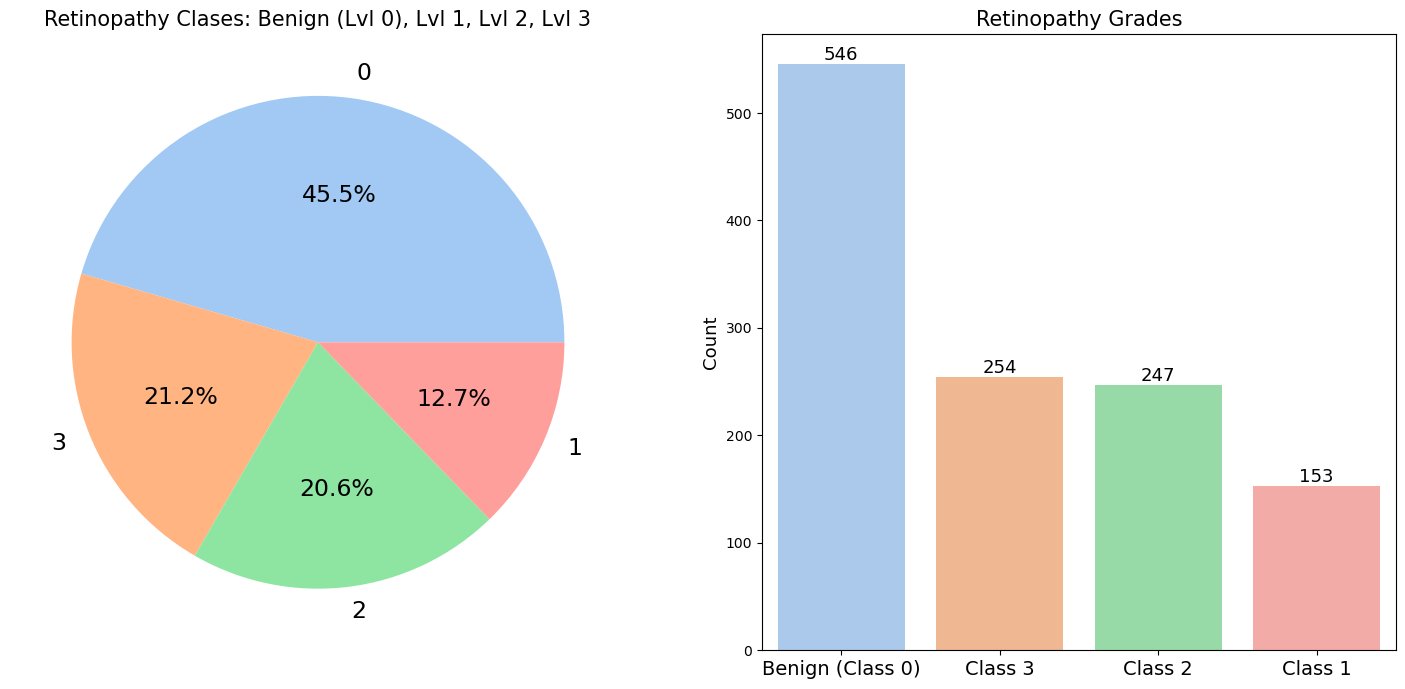

In [30]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#Checking class balance (0: Benign, 1, 2, 3) for main label
fig, ax = plt.subplots(1,2, figsize=(18,8))
retina_data['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], fontsize=17, 
                                             colors=sns.color_palette('pastel')[0:5])
ax[0].set_title('Retinopathy Clases: Benign (Lvl 0), Lvl 1, Lvl 2, Lvl 3', fontsize=15)
ax[0].set_ylabel('')
#Countplot for label
sns.countplot('label', data=retina_data, ax=ax[1], order=retina_data['label'].value_counts().index, 
              palette=sns.color_palette('pastel')[0:5]) # palette='coolwarm'
ax[1].bar_label(ax[1].containers[0], fontsize=13)
ax[1].set_title('Retinopathy Grades', fontsize=15)
ax[1].set_ylabel('Count', fontsize=13)
ax[1].set_xlabel('', fontsize=15)
ax[1].set_xticklabels(['Benign (Class 0)', 'Class 3', 'Class 2', 'Class 1'], fontsize=14)
plt.show()

## 3.5 Exploring Images and Properties<a id='3.5_expl_p'></a>

Now that we have our image database created, let's explore the properties of the images and the types of operations and processing we can do on them.

In [31]:
# list file and directories
file_names = os.listdir(dir_path+'\data_processed\data_original')
display(len(file_names)) # checking how many images we have in out data_original database

1200

### 3.5.1 Inspecting images per class visually <a id='3.5.1_expl_i_v'></a>

In this section, we will explore the images by label and see if we can spot some evident differences visually between them. In this sense, let's load a couple of images from each class and have a (non-clinical, just exploratory) look. 

Although we are not clinicians, we can take this image taken from this [resource](), to basically guide us on what to see on each retinography

<p style="text-align:center;"><img src="https://www.researchgate.net/profile/Enrique-Carmona/publication/318647256/figure/fig9/AS:631664195665963@1527611888818/Main-anatomical-structures-to-consider-in-a-retinal-image-right-eye.png" alt="Drawing" style="width: 500px;"/></p>

Let's subset our tabular data frame to later pick random image file names that will serve for plotting purposes per each class.

In [32]:
# subsetting classes and getting a list of image file names
c_0 = list(retina_data.loc[retina_data['label'] == 0, 'Image name']) 
c_1 = list(retina_data.loc[retina_data['label'] == 1, 'Image name'])
c_2 = list(retina_data.loc[retina_data['label'] == 2, 'Image name'])
c_3 = list(retina_data.loc[retina_data['label'] == 3, 'Image name'])

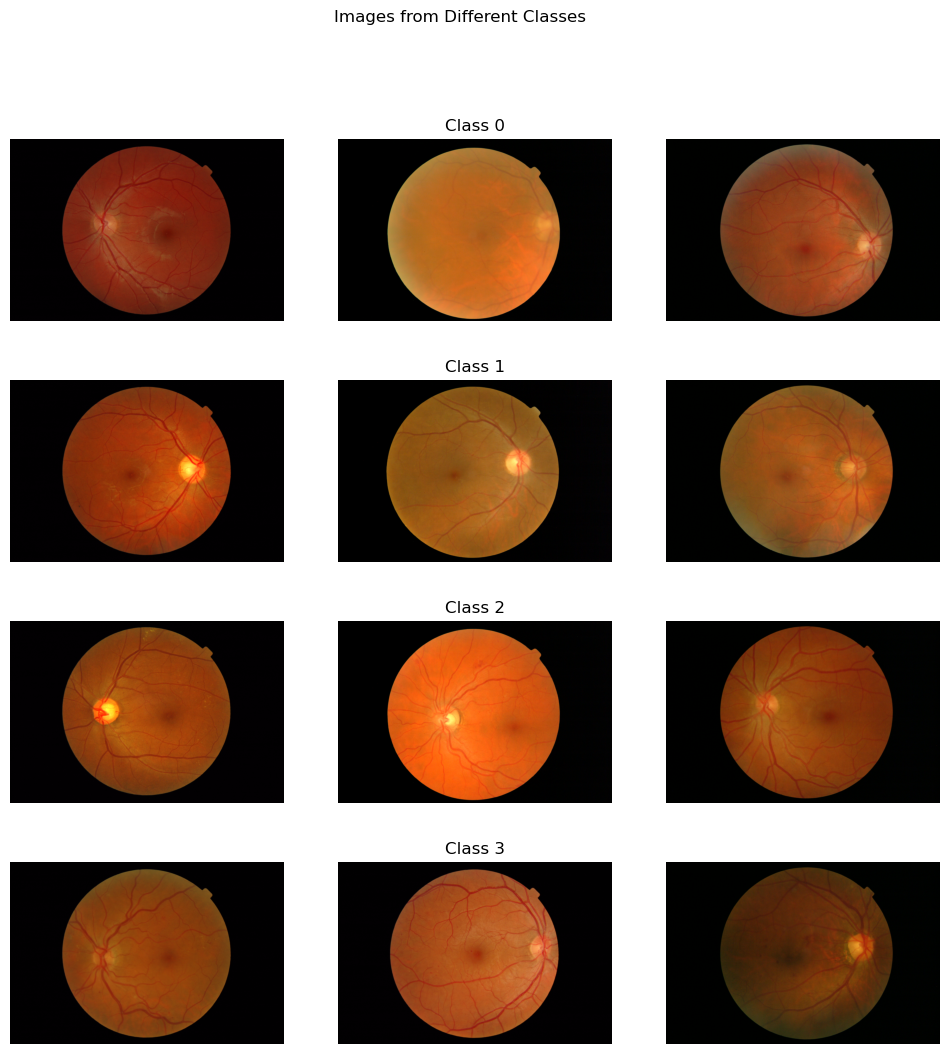

In [33]:
# setting different parameters to adjust each grid
fig, axs = plt.subplots(4, 3, figsize=(12,12))
fig.suptitle('Images from Different Classes')

# plotting Class 0 images
axs[0,0].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_0[2])))
axs[0,0].set_axis_off()
axs[0,1].set_title('Class 0')

axs[0,1].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_0[round(len(c_0)/2)])))
axs[0,1].set_axis_off()

axs[0,2].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_0[-2])))
axs[0,2].set_axis_off()

# plotting Class 1 images
axs[1,0].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_1[2])))
axs[1,0].set_axis_off()
axs[1,1].set_title('Class 1')

axs[1,1].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_1[round(len(c_1)/2)])))
axs[1,1].set_axis_off()

axs[1,2].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_1[-2])))
axs[1,2].set_axis_off()

# plotting Class 2 images
axs[2,0].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_2[2])))
axs[2,0].set_axis_off()
axs[2,1].set_title('Class 2')

axs[2,1].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_2[round(len(c_2)/2)])))
axs[2,1].set_axis_off()

axs[2,2].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_2[-2])))
axs[2,2].set_axis_off()

# plotting Class 3 images
axs[3,0].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_3[2])))
axs[3,0].set_axis_off()
axs[3,1].set_title('Class 3')

axs[3,1].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_3[round(len(c_3)/2)])))
axs[3,1].set_axis_off()

axs[3,2].imshow(plt.imread(dir_path+'\data_processed\data_original\{}'.format(c_3[-2])))
axs[3,2].set_axis_off()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

It is kind of challenging to spot the differences between healthy and unhealthy retinography by just looking at the images like we are doing now. However, since diabetic retinopathy is a disease that impacts directly to the blood vessels, our main target will be to highlight the blood vessels from the image and make analysis on them. 

## 3.6 Balancing Data<a id='3.6_baln_d'></a>

Since we want to have a similar number of classes, we will be doing some data augmentation on this stage by just simply flipping some images taken from class 1 mainly but also from classes 2 and 3 until we get 260 images of each. These images will be then saved to the data_original database for our further input to the model.

Let's start with **Class 1** augmentation

In [34]:
images_class1 = retina_data[retina_data['label'] == 1] # subsetting dataset to take some files
images_class1.head()

,Image name,Zip File,Image Size,label,Risk of macular edema
2,20051020_43832_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0
16,20051020_44782_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0
32,20051020_55701_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0
33,20051020_56592_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0
48,20051020_61998_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0


In [35]:
images_class1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 2 to 1181
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              153 non-null    object
 1   Zip File                153 non-null    object
 2   Image Size              153 non-null    object
 3   label                   153 non-null    int64 
 4   Risk of macular edema   153 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 7.2+ KB


### 3.6.1 Exploring class distribution<a id='3.6.1_expl_cld'></a>

To distribute as evenly as possible this sampling, we will take 9 Class 1 images from each zip file (12 in total), in this way:

* 9 x 12 = 108 -> augmented Class 1 images
* 153 + 108 = **261** -> Class 1 images in total

But wait... does each zip file have at least 9 images of Class 1? Let's explore it

In [36]:
# list of zip files
zip_names = os.listdir(dir_path+'\data')
display(zip_names)

['Base11.zip',
 'Base12.zip',
 'Base13.zip',
 'Base14.zip',
 'Base21.zip',
 'Base22.zip',
 'Base23.zip',
 'Base24.zip',
 'Base31.zip',
 'Base32.zip',
 'Base33.zip',
 'Base34.zip']

In [37]:
# checking how many of class 1 images each zip file have
for zip_file in zip_names:
    print(zip_file, ':', len(list(retina_data[retina_data['label'] == 1][retina_data[retina_data['label'] == 1]['Zip File'] == zip_file]['Image name'])))

Base11.zip : 13
Base12.zip : 4
Base13.zip : 6
Base14.zip : 7
Base21.zip : 6
Base22.zip : 14
Base23.zip : 20
Base24.zip : 31
Base31.zip : 17
Base32.zip : 0
Base33.zip : 27
Base34.zip : 8


No! In fact, there are some files like Base32.zip that have no Class 1 images at all. Given this information, let's load all names of files in images_class1 data frame and randomly pop 44 elements from that list:

In [38]:
images_class1_list = list(images_class1['Image name'])
flag = 1

while flag < 45:
    try:
        images_class1_list.pop(np.random.randint(0, len(images_class1_list)+1))
        flag += 1
    except:
        pass

In [39]:
len(images_class1_list)

109

So, our new Class 1 images augmentation is:

* 153 + 109 = **262** -> Class 1 images in total

### 3.6.2 Applying manual data augmentation<a id='3.6.2_appll_mda'></a>

Now that we have a list of 109 Class 1 images, we will perform three types of transformations in them (randomly chosen) and then save the images into our image database and finally add the image name, label, and properties to our labels_sizes.csv file for later use. These are the transformations:

* Flip Vertically
* Flip Horizontally
* Gaussian Image Filter

Let's do that here:

In [40]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# transforming images and adding them to the databse
for file in images_class1_list:
    
    x = np.random.randint(1, 4) # random number to choose type of processing
    
    img_nparray = plt.imread(dir_path+'\data_processed\data_original\{}'.format(file)) # reading one file at a time
    
    if x == 1: # flip vertically
        img_fliplr = np.fliplr(img_nparray)
        imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), img_fliplr) # Saving images to path
    elif x == 2: # flip horizontally
        img_flipud = np.flipud(img_nparray)
        imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), img_flipud) # Saving images to path
    else: # gaussian transformation
        if np.random.randint(1, 10) > 5:
            gaussian_image = gaussian(img_nparray, channel_axis=True)
            gaussian_image = np.fliplr(gaussian_image) # flipping images randomly
            gaussian_image = img_as_ubyte(gaussian_image) # converting it back to binary
            imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), gaussian_image) # Saving images to path
        else:
            gaussian_image = gaussian(img_nparray, channel_axis=True)
            gaussian_image = img_as_ubyte(gaussian_image) # converting it back to binary
            imsave('{}\data_processed\data_original\A_{}'.format(dir_path, file), gaussian_image) # Saving images to path
    
    # saving generated observation in our retina_data data frame
    image_name_a = 'A_{}'.format(file)
    name_zip_a = retina_data.loc[retina_data['Image name']==file, 'Zip File'].values[0]
    image_size_a = retina_data.loc[retina_data['Image name']==file, 'Image Size'].values[0]
    label_a = retina_data.loc[retina_data['Image name']==file, 'label'].values[0]
    rme_a = retina_data.loc[retina_data['Image name']==file, 'Risk of macular edema '].values[0]
    
    # appending the row
    retina_data = retina_data.append({'Image name':image_name_a, 'Zip File':name_zip_a, 'Image Size':image_size_a,
                                'label':label_a, 'Risk of macular edema ':rme_a}, ignore_index=True)
    

### 3.6.3 Exploring image data and class balance<a id='3.6.3_expl_imda'></a>

Now that we have augmented 109 Class 1 images and added the information to the data frame, let's check its info: 

In [41]:
retina_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              1309 non-null   object
 1   Zip File                1309 non-null   object
 2   Image Size              1309 non-null   object
 3   label                   1309 non-null   int64 
 4   Risk of macular edema   1309 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 51.3+ KB


In [42]:
# saving the data frame to a csv file for later use
retina_data.to_csv(r'{}\data_processed\labels_sizes_aug.csv'.format(dir_path), index=False) # saving the dataframe to path

Great, we see consistency in the data frame since all dtypes are preserved and there are 1309 observations in it. So now let's check the class balance with this new data:

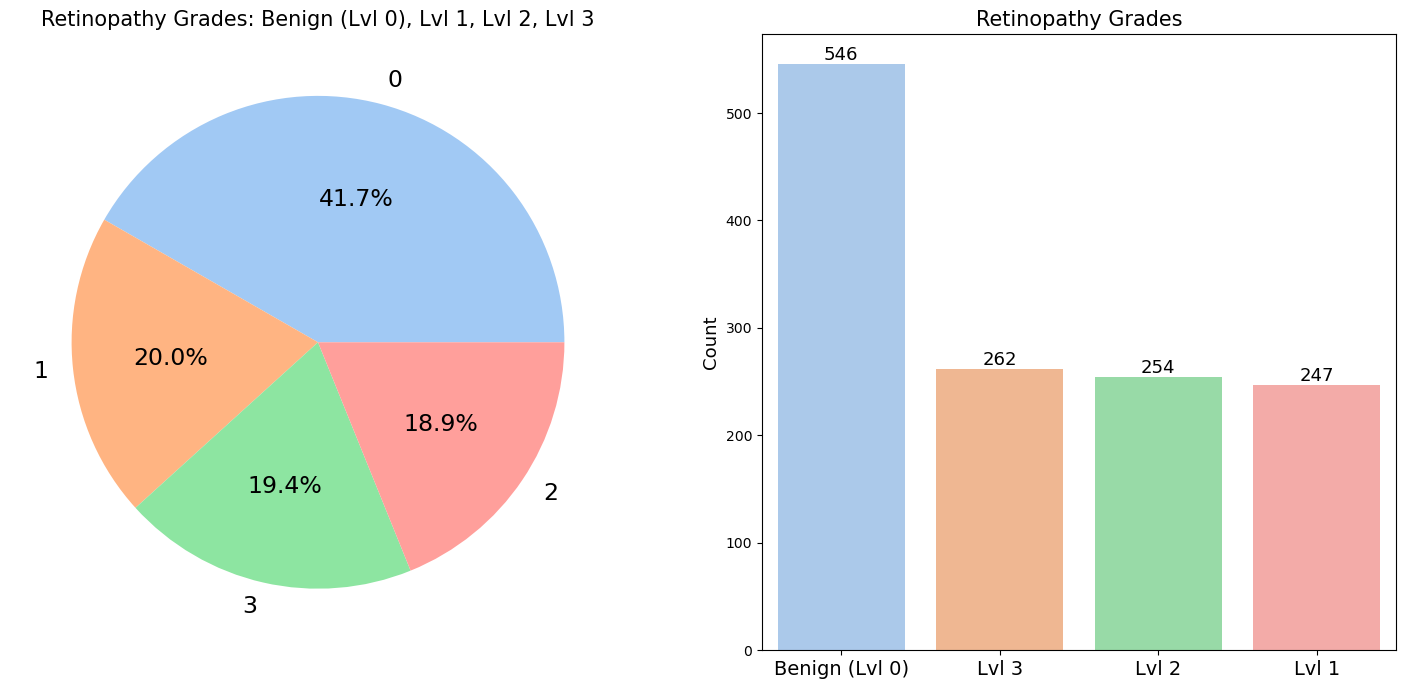

In [43]:
warnings.simplefilter(action='ignore', category=FutureWarning)
#Checking class balance (0: Benign, 1, 2, 3) for main label
fig, ax = plt.subplots(1,2, figsize=(18,8))
retina_data['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], fontsize=17, 
                                             colors=sns.color_palette('pastel')[0:5])
ax[0].set_title('Retinopathy Grades: Benign (Lvl 0), Lvl 1, Lvl 2, Lvl 3', fontsize=15)
ax[0].set_ylabel('')
#Countplot for label
sns.countplot('label', data=retina_data, ax=ax[1], order=retina_data['label'].value_counts().index, 
              palette=sns.color_palette('pastel')[0:5]) # palette='coolwarm'
ax[1].bar_label(ax[1].containers[0], fontsize=13)
ax[1].set_title('Retinopathy Grades', fontsize=15)
ax[1].set_ylabel('Count', fontsize=13)
ax[1].set_xlabel('', fontsize=15)
ax[1].set_xticklabels(['Benign (Lvl 0)', 'Lvl 3', 'Lvl 2', 'Lvl 1'], fontsize=14)
plt.show()

Ok, so now our data is better balanced than before (except for class 0, which is much larger than the other three).

The next step in this project is to generate a second database with the images processed in a way that can be suitable for a deep learning model. But before doing that task, we will explore what type of operations and processing can be done in the images.

We have used already three operations for the data augmentation steps:

* **Flipping (Vertical / Horizontal)**
* **Gaussian Filter**: applies blurring for reducing noise in the image.

But there are many others that will be very important and useful for this project. Let's explore a few.

In [44]:
# taking one sample image to work on
img_nparray = plt.imread(dir_path+'\data_processed\data_original\{}'.format(file_names[8]))

## 3.7 Types of Image Transformations / Operations <a id='3.7_typ_imt'></a>

In this section of the notebook, we will explore and compute different types of transformations and operations that can be done on each image to highlight properties in the data that could be added into the preprocessing stage of the project to have a better modeling. Let's jump right into it.

### 3.7.1 Reducing with antialiasing<a id='3.7.1_red_wan'></a>

Let's add an important concept on the reshaping transformation that can be done at the images which is called antialiasing. Antialiasing is a process which attempts to minimize the appearance of aliased diagonal edges. Anti-aliasing gives the appearance of smoother edges and higher resolution. It works by taking into account how much an ideal edge overlaps adjacent pixels.

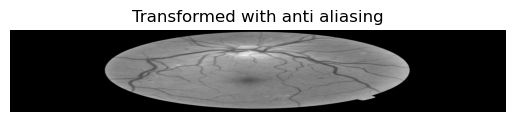

<class 'numpy.ndarray'> (372, 2240, 1)


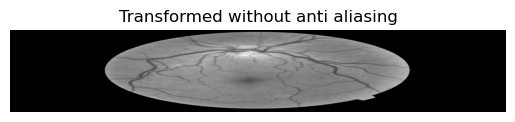

<class 'numpy.ndarray'> (372, 2240, 1)


In [45]:
# Rotate the image 90 degrees clockwise 
rotated_img = rotate(img_nparray, -90)

# Rescale with anti aliasing
rescaled_with_aa = rescale(rotated_img, 1/4, anti_aliasing=True, channel_axis=True)

# Rescale without anti aliasing
rescaled_without_aa = rescaled_with_aa = rescale(rotated_img, 1/4, anti_aliasing=False, channel_axis=True)

# Show the resulting images
h.show_image(rescaled_with_aa, "Transformed with anti aliasing")
h.show_image(rescaled_without_aa, "Transformed without anti aliasing")

Since we want the model to use as sharp images as possible, the use of aliasing will be questioned for further uses.

### 3.7.2 Getting the RGB channels (histograms)<a id='3.7.2_getrgb_ch'></a>

Since our images are in RGB-3D, we can explore each of the RGB channels in a separate way to determine what kind of thresholding filter we can apply to the images (if any). Let's extract and take a look at the histograms of each RGB channel.

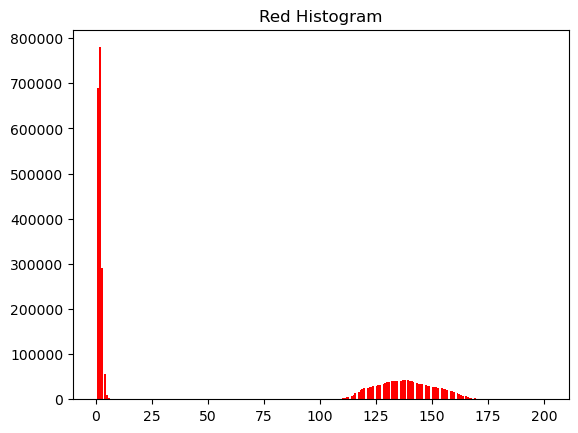

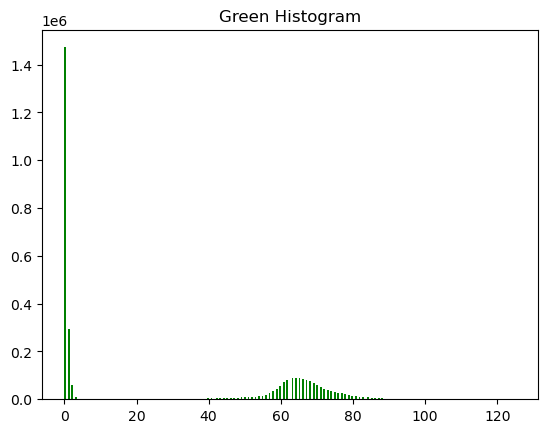

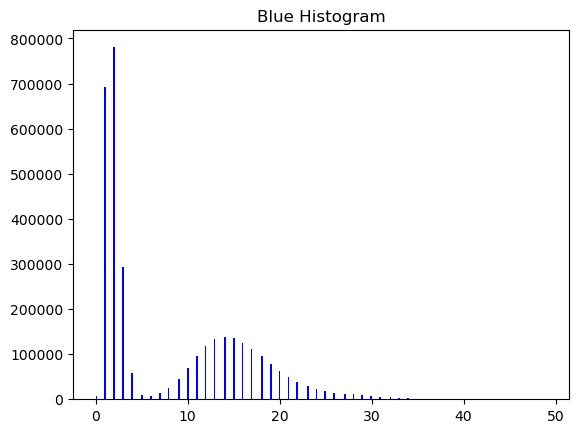

In [46]:
# Getting the RGB channels from the image
red_channel = img_nparray[:, :, 0] # Obtain the red channel
green_channel = img_nparray[:, :, 1] # Obtain the green channel
blue_channel = img_nparray[:, :, 2] # Obtain the blue channel

# Plot the red histogram with bins in a range of 256
plt.hist(red_channel.ravel(), bins=256, color='red')
# Set title and show
plt.title('Red Histogram')
plt.show()

# Plot the green histogram with bins in a range of 256
plt.hist(green_channel.ravel(), bins=256, color='green')
plt.title('Green Histogram')
plt.show()

# Plot the blue histogram with bins in a range of 256
plt.hist(blue_channel.ravel(), bins=256, color='blue')
plt.title('Blue Histogram')
plt.show()

From them we can see a predominance on the B channel (blue). This gives us a certain idea of the distribution of channels among our images useful for applying some thresholding filters, for instance.

But wait, before even trying to apply further operations to the images, we need to take a look at an extremely important one:

### 3.7.3 Converting to gray scale<a id='3.7.3_convt_g'></a>

This will be almost a critical step to take for data processing since most of the operations and transformations require that our images are in a 2D shape (or in gray scale). As of now, our images are in a RGB-3D shape.

In [47]:
img_nparray.shape

(1488, 2240, 3)

Now let's try converting the image to gray scale and analyze its resulting shape

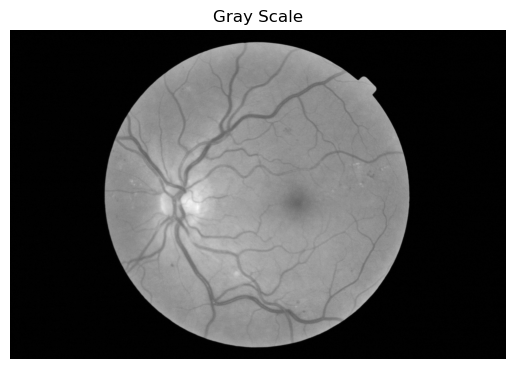

<class 'numpy.ndarray'> (1488, 2240)


In [48]:
# converting image from RGD-3D to gray scale
img_gray = color.rgb2gray(img_nparray)
h.show_image(img_gray, title='Gray Scale')

Now we passed from a (1488, 2240, 3) image to a (1488, 2240) image. Nice.

## 3.8 Types of Image Filtering <a id='3.8_typoif_i'></a>

In this section of the notebook, we will the type of image filters that can be applied to each image.

### 3.8.1 Filtering with thresholding<a id='3.8.1_fwt_i'></a>

So, we have been talking about thresholding for a couple of cells now. There are different types of thresholding that can be applied to the images. However, in this notebook, we will explore which one suits best (if any) to the images by trying all of them using the function try_all_threshold function from skimage.filters library.

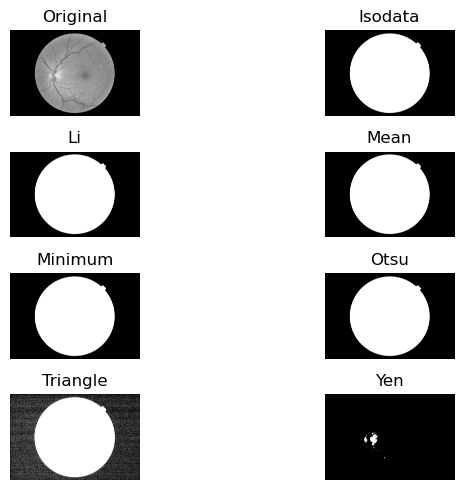

In [49]:
# Use the try_all method on the resulting grayscale image
fig, ax = try_all_threshold(img_gray, verbose=False)
# Show the resulting plots
plt.show()

As we can see from our previous plots, thresholding filters are not being so effective by just trying them out of the box. One probable explanation for this is the black background in all images which seems to be quite contrasting to our area of interest (rounded section). 

Anyways, let's continue by exploring different thresholding options and then explore how to tune these thresholding operations further for suitability.

### 3.8.2 Hysteresis thresholding<a id='3.8.2_fwt_h'></a>

One that we could try in this type of image is the thresholding with hysteresis. Hysteresis is the lagging of an effect like the concept of inertia. In the context of thresholding in image processing, it means that areas above some low thresholds are above the threshold if they are also connected to areas above a higher, more stringent, threshold. They can therefore be seen as continuations of these high-confidence areas.

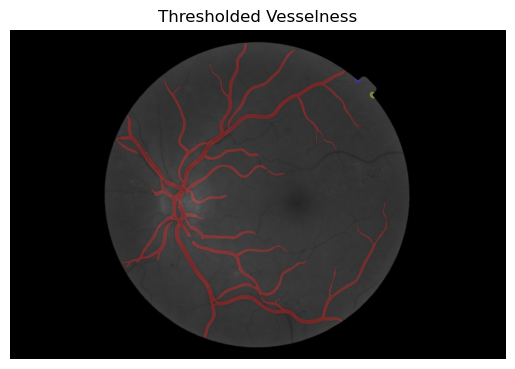

In [50]:
# Hysteresis Thresholding
t0, t1 = filters.threshold_multiotsu(img_gray, classes=3)
mask = (img_gray > t0)
vessels = filters.sato(img_gray, sigmas=range(1, 10)) * mask

thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, img_gray))
ax.set_axis_off()
_ = ax.set_title('Thresholded Vesselness')

As we can see, with this type of thresholding we can depict very visually the blood vessels in the retina. However, some of them (especially the small ones) are quite hard to catch by using this filter.

### 3.8.3 Edge detection <a id='3.8.3_edg_d'></a>

Computer vision problems and image recognition use cases make use of filtering for increasing performance in the model. Many of these applications heavily rely on basic shapes in the image that can be highlighted by the edges.

There is a Sobel filter that can do just that. Let's see how can we make use of it by utilizing the Sobel function from the skimage.filters library.

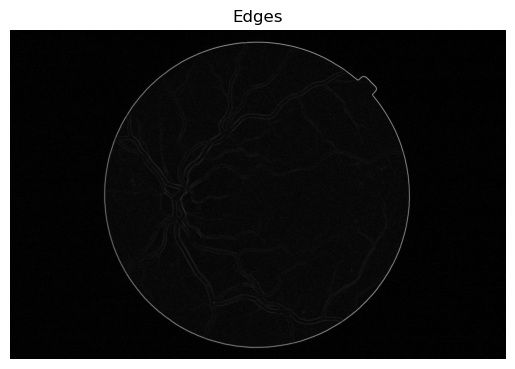

<class 'numpy.ndarray'> (1488, 2240)


In [51]:
# Make the image grayscale using rgb2gray
img_gray = color.rgb2gray(img_nparray)
img_edges = sobel(img_gray)
# Show the edged image
h.show_image(img_edges, 'Edges')

The thing is that we can only see the most prominent edge that is the circular shape of the image, which is not as useful as the internal blood vessels that are depicted just barely when applying this filter maybe because of its black background in the image. 

Having said that, why don't we try to invert the image and see the result. We can do this by applying the "gist_yarg" argument on our helper function. 

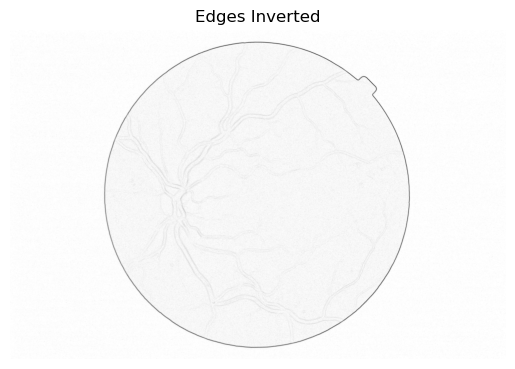

<class 'numpy.ndarray'> (1488, 2240)


In [52]:
# Show the edged image inverted
h.show_image(img_edges, title='Edges Inverted', cmap_type="gist_yarg")

Yes, that's better.

### 3.8.4 Edge detection with Canny<a id='3.8.4_edg_c'></a>

The Canny edge detection is the standard edge detection technique in image processing that produces high accuracy in detection edges and less execution time. The goal is to detect edges in the image and highlight them with thicker lines for spotting them more accurately.

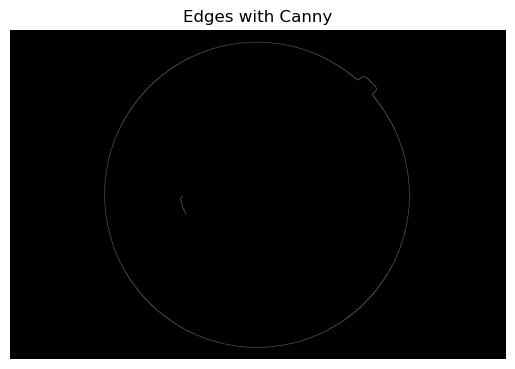

<class 'numpy.ndarray'> (1488, 2240)


In [53]:
# Apply Canny edge detector
canny_edges = canny(img_gray)
# Show resulting image
h.show_image(canny_edges, "Edges with Canny")

Barely useful. Let’s see if using different parameters for canny edge detection can increase the quality of the image displayed by making it less or more "edgy".

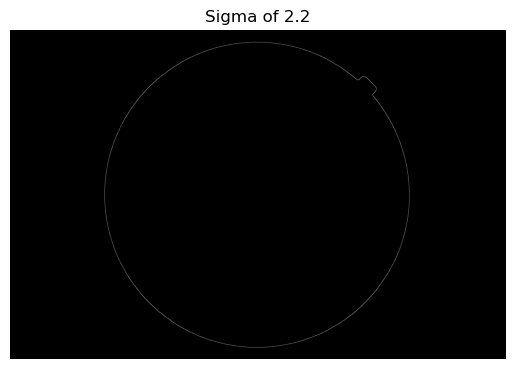

<class 'numpy.ndarray'> (1488, 2240)


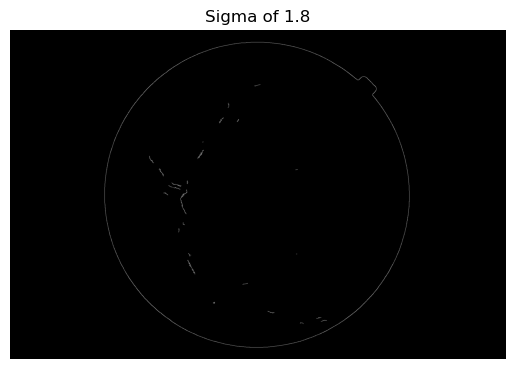

<class 'numpy.ndarray'> (1488, 2240)


In [54]:
# Apply Canny edge detector with a sigma of 1.8
edges_1_8 = canny(img_gray, sigma=0.002)
# Apply Canny edge detector with a sigma of 2.2
edges_2_2 = canny(img_gray, sigma=2.2)
# Show resulting images
h.show_image(edges_2_2, "Sigma of 2.2")
h.show_image(edges_1_8, "Sigma of 1.8")

We barely see any improvement; it doesn't seem to be a good operation for this type of image. Let's explore what we can do with the contrast.

### 3.8.5 Contrast enhancement<a id='3.8.5_contre_c'></a>

The contrast is the measure the dynamic range or the spread of the image's histogram. Contrast enhancement can be done by using the **contrast stretching techniques** which is used to stretch the histogram, so the full range of intensity values is filled. The other technique used is **histogram equalization** that spreads out the most frequent histogram intensities values using probability distribution. There are three types of histogram equalization:

1. **Standard Histogram Equalization:** Increasing overall contrast
2. **Adaptive Histogram Equalization:** This method computes several histograms, each corresponding to a distinct region of the image, and use them to redistribute the lightest values of the image histogram
3. **Contrast Limited Adaptive HE (CLAHE):** This is similar to 2 but it softness the noise in the image since it is not taking the global histogram but operates in small regions.

#### 3.8.5.1 Standard histogram equalization<a id='3.8.5.1_shw_i'></a>

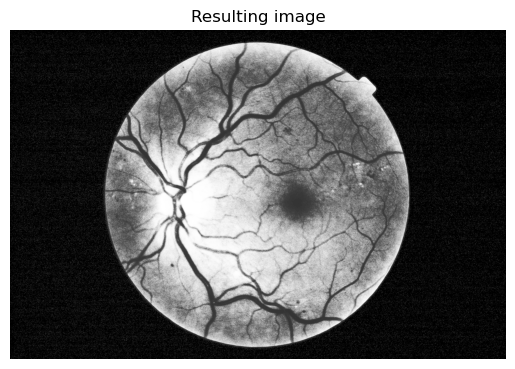

<class 'numpy.ndarray'> (1488, 2240)


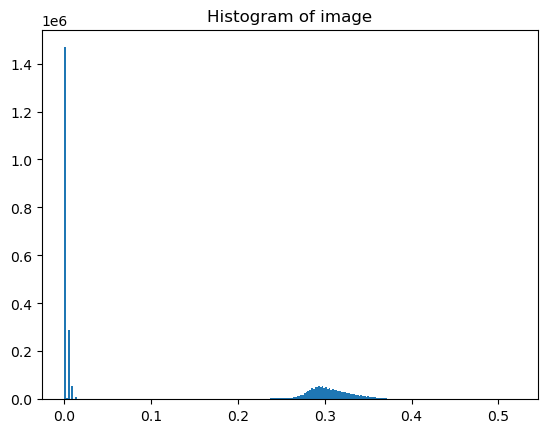

In [55]:
# Use histogram equalization to improve contrast
img_hist_eq = exposure.equalize_hist(img_gray)
# Show the resulting image
h.show_image(img_hist_eq, 'Resulting image')

# histogram
plt.title('Histogram of image')
plt.hist(img_gray.ravel(), bins=256)
plt.show()

Contrast enhancement is a very widely used technique in medical images (especially in radiological applications) since different contrast adjustments can depict different types of tissues. Like in this case, we can see that the large blood vessels are much more highlighted, but the small ones and other structures are lost a little bit. Therefore, a middle point or a definition of each parameter is important for determining what type of contrast enhancement is needed for each tissue. 

#### 3.8.5.2 CLAHE<a id='3.8.5.2_clahe_i'></a>

This technique does not need a binary image but can work with the RGB one. The main output of this filter application is an image with a more homogeneous background highly contrasted and reduced in noise. Let’s see it in action.

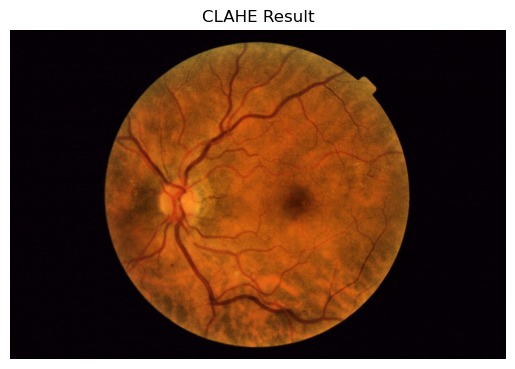

<class 'numpy.ndarray'> (1488, 2240, 3)


In [56]:
# Apply adaptive equalization on the original image
adapthist_eq_image = exposure.equalize_adapthist(img_nparray, clip_limit=0.02)

# Compare original image to the equalized one
h.show_image(adapthist_eq_image, 'CLAHE Result')

### 3.8.6 Vesselness filter function<a id='3.8.6_vff_i'></a>

Now it is time to take a look at the performance of filters found in the documentation of skimage.filters library.

The first one we will use is going to be a filter named Vesselnes Filter that will be using a multi Otsu thresholding and 3 classes for filtering the image, then applying a Sato filter to the image and plot it in a magma color map.

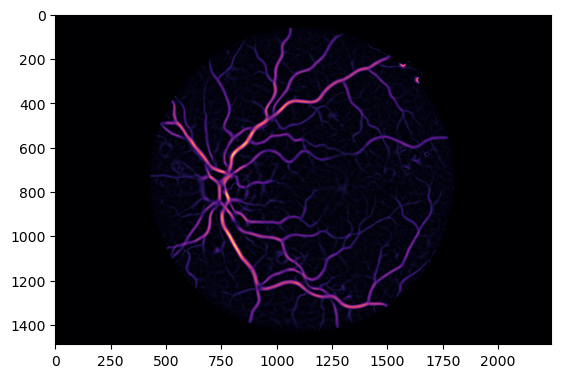

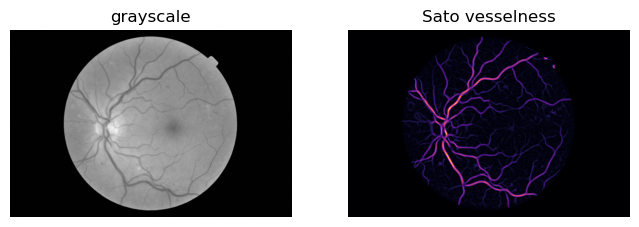

In [57]:
# vesselnes filter function
t0, t1 = filters.threshold_multiotsu(img_gray, classes=3)
mask = (img_gray > t0)
vessels = filters.sato(img_gray, sigmas=range(1, 10)) * mask
plt.imshow(vessels, cmap='magma')

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

This looks visually very impressive, but is it going to be the best processing to apply for inputting the data in a deep learning algorithm? There is only one way to know.

## 3.9 Skeletonize Operations<a id='3.9_skltn'></a>

Let's see what features we can extract from the images by using another function included in the documentation called skeletonize. Skeletonization is a process for reducing foreground regions in a binary image to a skeletal remnant that largely preserves the extent and connectivity of the original region while throwing away most of the original foreground pixels. 

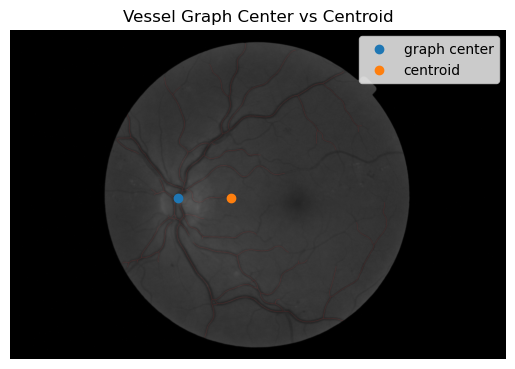

In [58]:
largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
binary = labeled == largest_nonzero_label
skeleton = morphology.skeletonize(binary)
g, nodes = graph.pixel_graph(skeleton, connectivity=2)
px, distances = graph.central_pixel(
        g, nodes=nodes, shape=skeleton.shape, partition_size=100
        )

centroid = measure.centroid(labeled > 0)

_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton, img_gray))
ax.scatter(px[1], px[0], label='graph center')
ax.scatter(centroid[1], centroid[0], label='centroid')
ax.legend()
ax.set_axis_off()
ax.set_title('Vessel Graph Center vs Centroid')

plt.show()

## 3.10 Other Types of Operations<a id='3.10_otop'></a>

### 3.10.1 Morphology <a id='3.10.1_morph'></a>

Basic Morphological Operations Include:

1. **Dilation:** Adds pixels to the boundaries of the objects in an image
2. **Erotion:** Removes pixels on object's boundaries

The number of pixels added or removed to an image depends on the size and shape of a structuring element used to process the image (like a kernel).

### 3.10.2 Segmentation<a id='3.10.2_Segment'></a>

The goal is to change the representation into something more meaningful and easier to analyze by increasing computational efficiency, the segmentation is done by using super pixels. Thresholding is the simplest method for segmentation.

**Super pixel:** group of connected pixels with similar color or gray levels

Segmentation can be done in a supervised or unsupervised way. Supervised when prior information like threshold values is provided before the segmentation. Unsupervised is when there is no information given, for doing unsupervised we can apply a KNN-like model in the image to get some features from the image.

For this project however, segmentation will be only required for computational purposes since it should harm the resolution of the vessels in the image (objects of interest).

### 3.10.3 Numpy array operations<a id='3.10.3_nparro'></a>

At the end of the day, images are being read as numpy arrays or matrices of data and all operations and transformations explained previously are just that: matrix operations. 

Additionally, to those already built, there are some useful and very important 'low-level' operations that can be done on these numbers directly using numpy to have a normalized and standardized data. These operations will be done in the processing stage of the project (04_preprocessing_modeling) but will be explained briefly here. 

**Standardization** is going to put the pixel values into the interval [0,1] by scaling with 1/255.


## 3.11 Summary of Useful Operations / Transformations<a id='3.11_summ'></a>

In the next cell, we will show a couple of image transformations / operations that have been useful for this project (manual data augmentation stage) and that could be considered for the preprocessing and modeling stage of the project, we will plot them visually to have a better picture on what is the operation doing to the image.

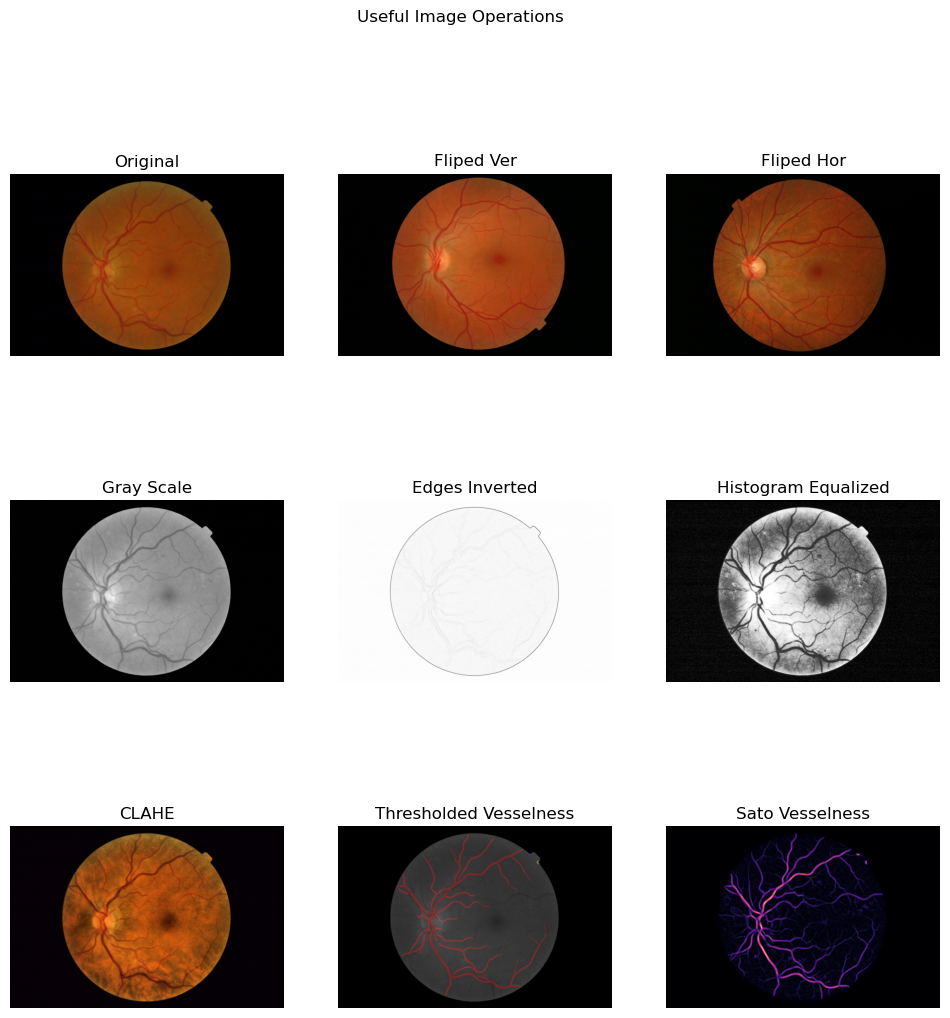

In [59]:
# setting different parameters to adjust each grid
fig, axs = plt.subplots(3, 3, figsize=(12,12))
fig.suptitle('Useful Image Operations')

axs[0,0].imshow(img_nparray, cmap='gray')
axs[0,0].set_axis_off()
axs[0,0].set_title('Original')

axs[0,1].imshow(img_flipud, cmap='gray')
axs[0,1].set_axis_off()
axs[0,1].set_title('Fliped Ver')

axs[0,2].imshow(img_fliplr, cmap='gray')
axs[0,2].set_axis_off()
axs[0,2].set_title('Fliped Hor')

axs[1,0].imshow(img_gray, cmap='gray')
axs[1,0].set_axis_off()
axs[1,0].set_title('Gray Scale')

axs[1,1].imshow(img_edges, cmap="gist_yarg")
axs[1,1].set_axis_off()
axs[1,1].set_title('Edges Inverted')

axs[1,2].imshow(img_hist_eq, cmap='gray')
axs[1,2].set_axis_off()
axs[1,2].set_title('Histogram Equalized')

axs[2,0].imshow(adapthist_eq_image)
axs[2,0].set_axis_off()
axs[2,0].set_title('CLAHE')

axs[2,1].imshow(color.label2rgb(labeled, img_gray))
axs[2,1].set_axis_off()
axs[2,1].set_title('Thresholded Vesselness')

axs[2,2].imshow(vessels, cmap='magma')
axs[2,2].set_axis_off()
axs[2,2].set_title('Sato Vesselness')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## 3.12 Summary<a id='3.12_summary'></a>

In this EDA stage we found some interesting properties in our both tabular and image data, so let's divide them in two to wrap-up this stage:

**Tabular Data**
- Each feature in the dataset is consistent with its datatype so there is no need to engineer or handle anything on datatypes
- there are no null values on the dataset so there is no need for null-values handling
- The id of each image is now homogeneous and can be matched to each image file
- All the image id's (image file names) are unique
- During tabular data analysis we could identify class imbalance having more class 0 images than others

**Image Data**
- It is very difficult to spot class differences visually without a clinical eye
- We decided to go with a manual data augmentation on class 1 images since it was the class with less information
- For the manual data augmentation, we only did basic transformations on the images like flipping and Gaussian filters
- We were able to explore very interesting operations / transformations / filters that can be applied on the images before trying to input them to the model. However, in the next stage, we are only trying first the pretty basic ones before jumping into more advanced operations on images and checking the performance of the model. 